In [1]:
ls /home/donglai/public/xupeng_toufiq_code/

ecs-syn-tst-groundtruth-polarity.h5*
gt-4x6x6/
result_ecs-4x6x6-100K-40000-itr3-thd0.1_xml_m.h5*
synapse_15.00-4.00-104-900-15000-400-4.h5
synapse_15.00-4.00-104-900-15000-400-4.json
synapse_statistics.csv
test_ecs_synapse_polarity_full_margin_linear_leaky_f24_316_32_196000-cropped.h5*


In [2]:
cd /home/donglai/public/xupeng_toufiq_code

/home/donglai/public/xupeng_toufiq_code


In [3]:
%pylab inline
import h5py
import numpy as np
from ipywidgets import interact
from itertools import product
pylab.rcParams["figure.figsize"] = (12, 12)

Populating the interactive namespace from numpy and matplotlib


In [4]:
seg_path = "result_ecs-4x6x6-100K-40000-itr3-thd0.1_xml_m.h5"
pred_path = "test_ecs_synapse_polarity_full_margin_linear_leaky_f24_316_32_196000-cropped.h5"

In [5]:
with h5py.File(seg_path, "r") as fd:
    print (list(fd.keys()))

['stack']


In [6]:
with h5py.File(pred_path, "r") as fd:
    pred = fd[list(fd.keys())[0]][:]
with h5py.File(seg_path, "r") as fd:
    seg = fd[list(fd.keys())[0]][:]

In [7]:
pred.shape, seg.shape, pred.dtype, seg.dtype

((145, 1496, 1496), (145, 1496, 1496), dtype('<f4'), dtype('uint32'))

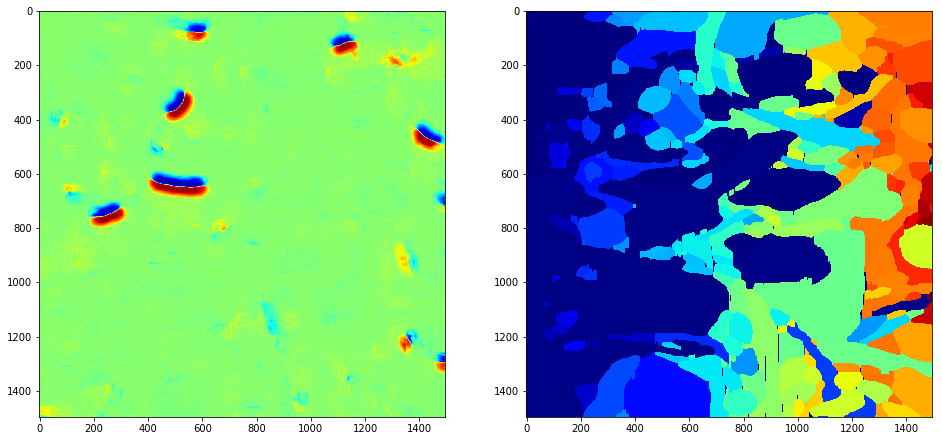

In [8]:
layerind = 30
fig, ax=plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(pred[layerind],cmap='jet')
ax[1].imshow(seg[layerind],cmap='jet')

In [9]:
abspred = (np.clip(np.abs(pred), 0, 1) * 255).astype(np.uint8)

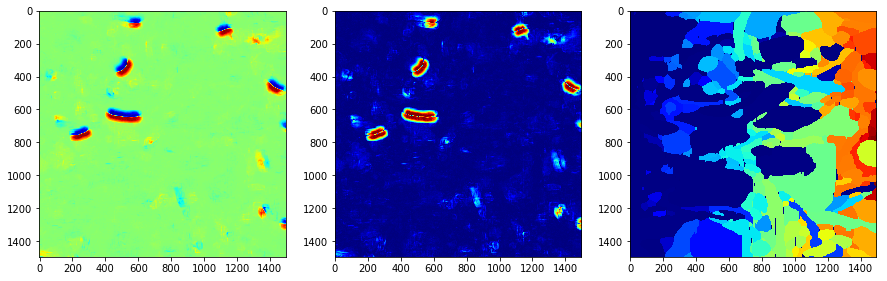

In [10]:
layerind = 30
fig, ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(pred[layerind],cmap='jet')
ax[1].imshow(abspred[layerind],cmap='jet')
ax[2].imshow(seg[layerind],cmap='jet')

In [11]:
gt_syn_path = "gt-4x6x6/synapse_groundtruth.h5"
with h5py.File(gt_syn_path, "r") as fd:
    gt_syn = fd[list(fd.keys())[0]][:]
gt_syn.shape

(145, 1496, 1496)

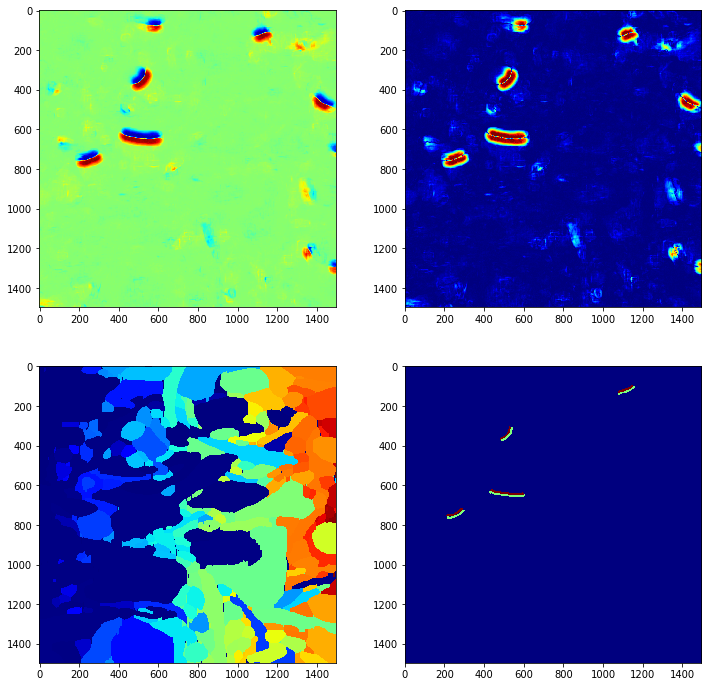

In [12]:
layerind = 30
fig, ax=plt.subplots(2,2,figsize=(12,12))
ax[0,0].imshow(pred[layerind],cmap='jet')
ax[0,1].imshow(abspred[layerind],cmap='jet')
ax[1,0].imshow(seg[layerind],cmap='jet')
ax[1,1].imshow(gt_syn[layerind],cmap='jet')

In [13]:
bbdd =binary_dilation(gt_syn > 0, structure=np.ones((3, 7, 7), bool))

NameError: name 'binary_dilation' is not defined

In [ ]:
from scipy.ndimage import binary_dilation, label, binary_erosion
gt_syn_np, count = label(binary_dilation(gt_syn > 0, structure=np.ones((3, 7, 7), bool)))
count

### dilate gt-syn to have bigger one

In [ ]:
layerind = 30
fig, ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(gt_syn[layerind],cmap='jet')
ax[1].imshow(gt_syn_np[layerind],cmap='jet')

### img and gt-seg

In [ ]:
gt_seg_path = "gt-4x6x6/seg_groundtruth0.h5"
with h5py.File(gt_seg_path, "r") as fd:
    gt_seg = fd[list(fd.keys())[0]][:]
img_path = "gt-4x6x6/gt-4x6x6_image.h5"
with h5py.File(img_path, "r") as fd:
    img = fd[list(fd.keys())[0]][:]
gt_seg.shape,img.shape

In [ ]:
layerind = 30
fig, ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(gt_seg[layerind],cmap='gray')
ax[1].imshow(img[layerind],cmap='gray')

In [11]:
from ariadne_microns_pipeline.algorithms.segmentation import segment_vesicle_style
from ariadne_microns_pipeline.algorithms.evaluation import match_synapses_by_overlap

### some functions in 
https://github.com/microns-ariadne/pipeline_engine

In [ ]:
def segment_vesicle_style(prob,
                         sigma_xy,
                         sigma_z,
                         threshold,
                         min_size_2d,
                         max_size_2d,
                         min_size_3d,
                         min_slice):
    '''Segment according to the "Vesicle" algorithm
    See http://arxiv.org/abs/1403.3724
    VESICLE: Volumetric Evaluation of Synaptic Interfaces using Computer
             vision at Large Scale
    William Gray Roncal, Michael Pekala, Verena Kaynig-Fittkau, 
    Dean M. Kleissas, Joshua T. Vogelstein, Hanspeter Pfister, Randal Burns, 
    R. Jacob Vogelstein, Mark A. Chevillet, Gregory D. Hager
    :param prob: The synapse probability volume with axes of z, y, and x
    :param sigma_xy: The sigma for the smoothing gaussian in the x and y
                     directions
    :param sigma_z: The sigma for the smoothing Gaussian in the z direction
    :param threshold: The probability threshold above which, a voxel is
                      deemed to be part of a synapse.
    :param min_size_2d: discard any 2d segments with area less than this.
    :param max_size_2d: discard any 2d segments with area greater than this.
    :param min_size_3d: discard any 3d segments with area less than this.
    :param min_slice: discard any 3d segments whose z-extent is less than this.
    '''

    fg = gaussian_filter(prob.astype(np.float32),
                         (sigma_z, sigma_xy, sigma_xy)) > threshold
    #
    # 2D filter by area
    #
    strel = np.array([[False, True, False],
                      [ True, True, True],
                      [False, True, False]])
    for z, plane in enumerate(fg):
        l, count = label(plane)
        areas = np.bincount(l.flatten())
        bad = np.zeros(areas.shape[0], bool)
        bad[areas < min_size_2d] = True
        bad[areas > max_size_2d] = True
        fg[z, bad[l]] = False
    #
    # 3D filter by area
    #
    strel = np.array([[[False, False, False],
                       [False, True, False],
                       [False, False, False]],
                      [[False, True, False],
                       [True,  True, True],
                       [False, True, False]],
                      [[False, False, False],
                       [False, True, False],
                       [False, False, False]]])
    l, count = label(fg, strel)
    areas = np.bincount(l.flatten())
    bad = areas < min_size_3d
    #
    # 3D filter by z
    #
    for i, location in enumerate(find_objects(l)):
        if location is None:
            bad[i+1] = True
        z = location[0]
        if z.stop - z.start < min_slice:
            bad[i+1] = True
    fg[bad[l]] = False
    #
    # Do 18-connected connected-components
    #
    strel = np.ones((3, 3, 3), bool)
    for z in 0, -1:
        for y in 0, -1:
            for x in 0, -1:
                strel[z, y, x] = False
    l, count = label(fg, strel)
    return l

In [ ]:
def match_synapses_by_overlap(gt, detected, min_overlap_pct, \
                              min_gt_overlap_pct=None):
    '''Determine the best ground truth synapse for a detected synapse by overlap
    
    :param gt: the ground-truth labeling of the volume. 0 = not synapse,
               1+ are the labels for each synapse
    :param detected: the computer-generated labeling of the volume
    :param min_overlap_pct: the percentage of voxels that must overlap
               for the algorithm to consider two objects.
    :param min_gt_overlap_pct: the percentage of gt voxels that must overlap
               detected voxels to score an overlap. Defaults to min_overlap_pct
    
    The algorithm tries to maximize the number of overlapping voxels
    globally. It finds the overlap between each pair of gt and detected
    objects. The cost is the number of voxels uncovered by both, given the
    choice.
    
    There must be an alternative cost for each gt matching nothing and
    for each detected matching nothing. This is the area of the thing minus
    the min_overlap_pct so that anything matching less than the min_overlap_pct
    will match against nothing.
    
    Return two vectors. The first vector is the matching label in d for each
    gt label (with zero for "not a match"). The second vector is the matching
    label in gt for each detected label.
    '''
    if min_gt_overlap_pct is None:
        min_gt_overlap_pct = min_overlap_pct
    gt_areas = np.bincount(gt.flatten())
    gt_areas[0] = 0
    #
    # gt_map is a map of the original label #s for the labels that are > 0
    #        We work with the gt_map indices, nto the label #s
    # gt_r_map goes the other way
    #
    gt_map = np.where(gt_areas > 0)[0]
    gt_r_map = np.zeros(len(gt_areas), int)
    n_gt = len(gt_map)
    gt_r_map[gt_map] = np.arange(n_gt)
    #
    # for detected...
    #
    d_areas = np.bincount(detected.flatten())
    d_areas[0] = 0
    d_map = np.where(d_areas > 0)[0]
    d_r_map = np.zeros(len(d_areas), int)
    n_d = len(d_map)
    d_r_map[d_map] = np.arange(n_d)
    #
    # Get the matrix of correspondences.
    #
    z, y, x = np.where((gt > 0) & (detected > 0))
    matrix = coo_matrix((np.ones(len(z), int), 
                         (gt_r_map[gt[z, y, x]], 
                          d_r_map[detected[z, y, x]])),
                        shape=(n_gt, n_d))
    matrix.sum_duplicates()
    matrix = matrix.toarray()
    #
    # Enforce minimum overlap
    #
    d_min_overlap = d_areas[d_map] * min_overlap_pct / 100
    gt_min_overlap = gt_areas[gt_map] * min_gt_overlap_pct / 100
    bad_gt, bad_d = np.where((matrix < gt_min_overlap[:, np.newaxis]) |
                             (matrix < d_min_overlap[np.newaxis, :]))
    matrix[bad_gt, bad_d] = 0
    #
    # The score of each cell is the number of voxels in each cell minus
    # double the overlap - the amount of voxels covered in each map by
    # the overlap.
    #
    matrix = \
        gt_areas[gt_map][:, np.newaxis] +\
        d_areas[d_map][np.newaxis, :] -\
        matrix
    #
    # The alternative is that the thing matches nothing. We augment
    # the matrix with alternatives for each object, for instance:
    #
    # DA3 inf inf x   0    0
    # DA2 inf x   inf 0    0
    # DA1 x   inf inf 0    0
    # G2  y   y   y   inf  x
    # G1  y   y   y   x    inf
    #     D1  D2  D3  GA1  GA2
    #
    # x is the area of the thing * (1 - min_pct_overlap)
    # y is the area of both things - 2x overlap
    #
    big_matrix = np.zeros((n_gt+n_d, n_gt+n_d), np.float64)
    big_matrix[:n_gt, :n_d] = matrix
    big_matrix[n_gt:, :n_d] = np.inf
    big_matrix[:n_gt, n_d:] = np.inf
    #
    # The "eps" here is present to guarantees that the hungarian will take the
    # alternative if there is no overlap.
    #
    eps = np.finfo(np.float32).eps
    big_matrix[n_gt+np.arange(n_d), np.arange(n_d)] = d_areas[d_map] - eps
    big_matrix[np.arange(n_gt), n_d+np.arange(n_gt)] = gt_areas[gt_map] - eps
    #
    # There's a problem with hungarian.lap where it can't solve if all
    # rows or columns has no members less than infinity. This would not be
    # a problem except that hungarian's "infinity" is 100,000. Rescale to
    # make every non-infinite element less than 100,000
    #
    hungarian_inf = 100000
    mmax = np.max(big_matrix[~np.isinf(big_matrix)])
    if mmax >= hungarian_inf:
        big_matrix = big_matrix / mmax
    #
    #
    # Solve it
    #
    d_match, gt_match = hungarian.lap(big_matrix)
    #
    # Get rid of the augmented results
    #
    d_match = d_match[:n_gt]
    gt_match = gt_match[:n_d]
    #
    # The gt with matches in d have d not in the alternative range
    #
    gt_winners = np.where(d_match < n_d)[0]
    gt_result = np.zeros(len(gt_areas), int)
    gt_result[gt_map[gt_winners]] = d_map[d_match[gt_winners]]
    #
    # Same for d
    #
    d_winners = np.where(gt_match < n_gt)[0]
    d_result = np.zeros(len(d_areas), int)
    d_result[d_map[d_winners]] = gt_map[gt_match[d_winners]]
    
    return gt_result, d_result

In [ ]:
from scipy.ndimage import gaussian_filter, label, find_objects

In [ ]:
syn_seg = segment_vesicle_style(np.abs(pred) * 255, 2.0, 2.0, 128, 200, 15000, 1000, 3)

In [ ]:
layerind = 30
fig, ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(pred[layerind],cmap='jet')
ax[1].imshow(syn_seg[layerind],cmap='jet')

### gt_syn_np: dilated gt synapse, syn_seg: post processed prediction
Return two vectors. 

The first vector is the matching label in d for each gt label (with zero for "not a match"). 

The second vector is the matching label in gt for each detected label.

In [ ]:
match_synapses_by_overlap(gt_syn_np, syn_seg, 10)

In [ ]:
def draw_synseg(idx):
    fig,ax=plt.subplots(1,figsize=(8,8))
    pylab.imshow(img[idx], cmap='gray')
    pylab.imshow(gt_syn_np[idx], cmap='tab20', alpha=.3)
    #pylab.imshow(pred[idx], alpha=.3)
    pylab.colorbar()
    pylab.show()
interact(draw_synseg, idx=(0, 144))

In [ ]:
from scipy.sparse import coo_matrix

def connect_synapses(synapse, neuron, probs, xy_dilation=3, z_dilation=0, min_contact=25):
    volume_mask = (synapse != 0) & (neuron != 0)
    svoxels = synapse[volume_mask]
    nvoxels = neuron[volume_mask]
    #
    # Make a matrix of counts of voxels in both synapses and neurons
    # then extract synapse / neuron matches
    #
    matrix = coo_matrix(
        (np.ones(len(nvoxels), int), (svoxels, nvoxels)))
    matrix.sum_duplicates()
    maxsynapses = matrix.shape[1] + 1
    synapse_labels, neuron_labels = matrix.nonzero()
    counts = matrix.tocsr()[synapse_labels, neuron_labels].getA1()
    #
    # Filter neurons with too little overlap
    #
    mask = counts >= min_contact
    #for i in counts:
        #print (i[mask])
    
    #counts = [_[mask] for _ in counts]
    #neuron_labels = [_[mask] for _ in  neuron_labels]
    #synapse_labels = [_[mask] for _ in  synapse_labels]
    counts, neuron_labels, synapse_labels = [mask[_] for _ in counts, neuron_labels, synapse_labels]
    #
    # Order by synapse label and -count to get the neurons with
    # the highest count first
    #
    order = np.lexsort((-counts, synapse_labels))
    #counts = [_[order] for _ in counts]
    #neuron_labels = [_[order] for _ in neuron_labels]
    #synapse_labels = [_[order] for _ in synapse_labels]
    #counts, neuron_labels, synapse_labels = [_[order] for _ in counts, neuron_labels, synapse_labels]
    first = np.hstack(
        [[True], synapse_labels[:-1] != synapse_labels[1:], [True]])
    idx = np.where(first)[0]
    per_synapse_counts = idx[1:] - idx[:-1]
    #
    # Get rid of counts < 2
    #
    mask = per_synapse_counts >= 2
    idx = idx[:-1][mask]
    #
    # pick out the first and second most overlapping neurons and
    # their synapse.
    #
    neuron_1 = neuron_labels[idx]
    synapses = synapse_labels[idx]
    neuron_2 = neuron_labels[idx+1]
    #
    # Start by making a matrix to transform the map.
    #
    neuron_mapping = np.hstack(([0], neuron_1, neuron_2))
    matrix = coo_matrix(
        (np.arange(len(idx)*2) + 1,
         (np.hstack((neuron_1, neuron_2)),
          np.hstack((synapses, synapses)))),
        shape=(np.max(nvoxels)+1, np.max(svoxels) + 1)).tocsr()
    #
    # Convert the neuron / synapse map to the mapping labels
    #
    mapping_labeling = matrix[nvoxels, svoxels]
    #
    # Score each synapse / label overlap on both the transmitter
    # and receptor probabilities
    #
    areas = np.bincount(mapping_labeling.A1)
    total_scores = np.bincount(
        mapping_labeling.A1, probs[volume_mask])
    score_1 = total_scores[1:len(idx)+1]
    score_2 = total_scores[len(idx)+1:]
    #
    # Flip the scores and neuron assignments if score_2 > score_1
    #
    flippers = score_2 > score_1
    score_1[flippers], score_2[flippers] = \
        score_2[flippers], score_1[flippers]
    neuron_1[flippers], neuron_2[flippers] = \
        neuron_2[flippers], neuron_1[flippers]
    return synapses, neuron_1, neuron_2

In [ ]:
np.column_stack(connect_synapses(syn_seg, seg, pred))

In [27]:
# Create a correspondence between the GT segmentation
# and the detected segmentation
#
mask = (gt_seg != 0) & (seg != 0)
gt_flat, seg_flat = [_[mask] for _ in gt_seg, seg]
matrix = coo_matrix((np.ones(gt_flat.shape, np.uint32), (seg_flat, gt_flat)))
matrix.sum_duplicates()
l_d, l_gt = matrix.nonzero()
count = matrix.tocsr()[l_d, l_gt].A1
#
# Now we find the counts that match the max for their detected label. 
# Ties go to whomever.
#
max_per_d = matrix.max(axis=1).toarray().flatten()
best = (count == max_per_d[l_d])
gt_per_seg = np.zeros(np.max(seg_flat)+1, np.uint32)
gt_per_seg[l_d[best]] = l_gt[best]
gt_per_seg[max_per_d == 0] = 0


In [25]:
gt_flat.shape, seg_flat.shape

((283401679,), (283401679,))

In [ ]:
import json
import tqdm
sigma_xy = np.linspace(.5, 10, 3)
sigma_z = np.linspace(.5, 4, 3)
threshold = np.linspace(80, 128, 3).astype(int)
min_size_2d = (np.linspace(10, 30, 3) ** 2).astype(int)
max_size_2d = np.array([15000])
min_size_3d = (np.linspace(20, 50, 3) ** 2).astype(int)
min_slice = np.arange(2, 5)
for isigma_xy, isigma_z, ithreshold, imin_size_2d, imax_size_2d, imin_size_3d, imin_slice in \
    tqdm.tqdm(list(product(sigma_xy, sigma_z, threshold, min_size_2d, max_size_2d, min_size_3d, min_slice))):
    args = (np.abs(pred)*255, isigma_xy, isigma_z, ithreshold, imin_size_2d, imax_size_2d,
            imin_size_3d, imin_slice)
    syn_seg = segment_vesicle_style(*args)
    detected_per_gt, gt_per_detected = match_synapses_by_overlap(gt_syn_np, syn_seg, 10)
    syn, neuron_1, neuron_2 = connect_synapses(syn_seg, seg, pred)
    path = "/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_%.2f-%.2f-%d-%d-%d-%d-%d" % (
        isigma_xy, isigma_z, ithreshold, imin_size_2d, imax_size_2d, imin_size_3d, imin_slice)
    with h5py.File(path+".h5", "w") as fd:
        fd.create_dataset("stack", data=syn_seg)
    d = dict(isigma_xy=isigma_xy, isigma_z=isigma_z, ithreshold=ithreshold, imin_size_2d=imin_size_2d,
             imax_size_2d=imax_size_2d, imin_size_3d=imin_size_3d, imin_slice=imin_slice,
             detected_per_gt = detected_per_gt.tolist(),
            gt_per_detected = gt_per_detected.tolist(),
            synapse=syn.tolist(),
            neuron_1=neuron_1.tolist(),
            neuron_2=neuron_2.tolist(),
            path=path+".h5")
    json.dump(d, open(path+".json", "w"))

 38%|███▊      | 277/729 [22:06:34<36:04:39, 287.34s/it]

In [30]:
np.sum(syn_seg)

0

In [77]:
def get_triplets(synapses, neurons):
    '''Get synapse, neuron, synapse triplets'''
    #
    # Sort the list by neuron-major, synapse-minor
    #
    order = np.lexsort((synapses, neurons))
    synapses, neurons = synapses[order], neurons[order]
    #
    # Get counts of # synapses per neuron
    #
    first = np.where(np.hstack([
        [True], neurons[1:] != neurons[:-1], [True]]))[0]
    counts=first[1:] - first[:-1]
    idx = first[:-1]
    #
    # Now there are (N * (N-1)) / 2 combinations for N synapses
    # attached to each neuron. We make tables for each N that do
    # the enumeration.
    #
    max_count = np.max(counts)
    tbl = np.zeros((max_count+1,
                    ((max_count * (max_count-1))/2),
                    2), int)
    for count in np.unique(counts):
        n = count * (count - 1) / 2
        if n == 0:
            continue
        a, b = np.mgrid[0:count, 0:count]
        a, b = a[a < b], b[a < b]
        tbl[count, :n, 0] = a
        tbl[count, :n, 1] = b
    #
    # The unique neurons:
    #
    first = first[:-1][counts > 1]
    uneurons = neurons[idx[counts > 1]]
    counts = counts[counts > 1]
    #
    # Create indices into above table
    #
    # neuron at index
    n_first = np.cumsum(np.hstack([[0], counts * (counts-1) / 2]))
    n_idx = np.zeros(n_first[-1], int)
    n_idx[n_first[1:-1]] = 1
    n_idx = np.cumsum(n_idx)
    #
    # synapse index
    #
    s_idx = np.arange(len(n_idx)) - n_first[n_idx]
    #
    # Use the combination table to read the offsets of the 
    # first and second synapses relative to the first occurence of
    # the neuron.
    #
    s1 = synapses[first[n_idx] + tbl[counts[n_idx], s_idx, 0]]
    s2 = synapses[first[n_idx] + tbl[counts[n_idx], s_idx, 1]]
    neuron = uneurons[n_idx]
    return s1, s2, neuron

gtl = np.unique(gt_syn_np[gt_syn_np != 0])
def synapse_statistics(path):
    #
    # Create all synapse-neuron-synapse triplets in the ground-truth
    #
    #
    # Get the detected synapses, mapping synapses to their gt
    # and neurons to their global labeling
    #
    s1_d = []
    s2_d = []
    n_d = []
    s_gt = []
    n_gt = []
    gt_labels = []
    tp_synapses = 0
    fp_synapses = 0
    fn_synapses = 0
    synapse_offset = 1
    synapse_map = []

    d_synapse_connections = json.load(open(path))
    #
    # The ground-truth synapse/neuron connections
    #
    gt_neuron = np.hstack([gt_neuron1, gt_neuron2])
    gt_synapse = np.hstack([gt_synapses]*2)
    #
    # The local label #s of the synapses. Doubled because each
    # synapse connects two neurons
    #
    l_synapse = np.hstack([d_synapse_connections["synapse"]] * 2)
    l_neuron = np.hstack([
        d_synapse_connections["neuron_1"],
        d_synapse_connections["neuron_2"]])
    #
    # map of gt synapses to detected
    #
    gt_per_detected = np.array(d_synapse_connections["gt_per_detected"])
    detected_per_gt = np.array(d_synapse_connections["detected_per_gt"])
    d_labels = np.arange(len(gt_per_detected)-1) + 1
    max_synapse = max(np.max(gt_synapse), len(detected_per_gt))
    global_synapse_labels = np.zeros(max_synapse + 1, int)
    global_synapse_labels[gtl] = \
        np.arange(len(gtl)) + synapse_offset
    synapse_offset += len(gtl)
    #
    # # of false synapses are those without correspondences
    # in the ground truth labels
    #
    fn_synapses += np.sum(detected_per_gt[gtl] == 0)
    tp_synapses += np.sum(gt_per_detected[d_labels] != 0)
    fp_synapses += np.sum(gt_per_detected[d_labels] == 0)
    to_keep = np.zeros(
        max(np.max(d_labels)+1, np.max(l_synapse))+1, bool)
    to_keep[d_labels] = True
    mask = to_keep[l_synapse]
    l_neuron = l_neuron[mask]
    l_synapse = l_synapse[mask]
    g_neuron = l_neuron
    #
    # Convert local synapse label # to the matching gt synapse
    # label #. Zero = no matching gt synapse.
    #
    # Note that there is no gt synapse with a label of zero,
    # so anything that pairs with a false positive synapse will
    # not be found in the true rendering of matching pairs.
    #
    g_synapse = global_synapse_labels[gt_per_detected[l_synapse]]
    #
    # Get the triples
    #
    s1_t, s2_t, n_t = get_triplets(g_synapse, g_neuron)
    #
    # Remove false positive detection <-> false positive detection
    #
    mask = (s1_t != 0) | (s2_t != 0)
    s1_t, s2_t, n_t = s1_t[mask], s2_t[mask], n_t[mask]
    s1_d.append(s1_t)
    s2_d.append(s2_t)
    n_d.append(n_t)
    #
    # Now do similar for gt_connections
    #
    gt_synapse = global_synapse_labels[gt_synapse]
    mask = gt_synapse != 0
    gt_synapse, gt_neuron = gt_synapse[mask], gt_neuron[mask]
    s_gt.append(gt_synapse)
    n_gt.append(gt_neuron)

    s_gt, n_gt = np.hstack(s_gt), np.hstack(n_gt)
    s1_d = np.hstack(s1_d)
    s2_d = np.hstack(s2_d)
    #
    # Make the detected matrix
    #
    d_matrix = coo_matrix((np.ones(len(s1_d)*2),
                           (np.hstack((s1_d, s2_d)),
                            np.hstack((s2_d, s1_d)))),
                          shape=(synapse_offset, synapse_offset)).tocsr()
    #
    # Make the gt matrix
    #
    s1_gt, s2_gt, n_gt = get_triplets(s_gt, n_gt)
    gt_matrix = coo_matrix((np.ones(len(s1_gt)*2),
                            (np.hstack((s1_gt, s2_gt)),
                             np.hstack((s2_gt, s1_gt)))),
                           shape=(synapse_offset, synapse_offset)).tocsr()
    #
    # Compile the results 
    #
    if len(s1_gt) == 0:
        true_positives = np.zeros(0, bool)
    else:
        true_positives = (d_matrix[s1_gt, s2_gt] != 0).A1
    tp_doublets = np.column_stack((s1_gt[true_positives],
                                   s2_gt[true_positives]))
    tp_doublets = tp_doublets[tp_doublets[:, 0] < tp_doublets[:, 1]]
    false_negatives = ~true_positives
    fn_doublets = np.column_stack((s1_gt[false_negatives],
                                   s2_gt[false_negatives]))
    fn_doublets = fn_doublets[fn_doublets[:, 0] < fn_doublets[:, 1]]
    if len(s1_d) == 0:
        false_positives = np.zeros(0, bool)
    else:
        false_positives = gt_matrix[s1_d, s2_d].A1 == 0
    fp_doublets = np.column_stack((s1_d[false_positives],
                                   s2_d[false_positives]))
    fp_doublets = fp_doublets[(fp_doublets[:, 0] < fp_doublets[:, 1]) &
                              (fp_doublets[:, 0] != 0)]
    n_true_positives = np.sum(true_positives)
    n_false_negatives = len(true_positives) - n_true_positives
    n_false_positives = np.sum(false_positives)
    precision = \
        float(n_true_positives) / \
        (n_true_positives + n_false_positives + np.finfo(float).eps)
    recall = \
        float(n_true_positives) / \
        (n_true_positives + n_false_negatives + np.finfo(float).eps)
    #
    # False negatives to add to pairs
    #
    s1_gt_fn = s1_gt[false_negatives]
    s2_gt_fn = s2_gt[false_negatives]
    #
    # Synapse stats
    #
    synapse_precision =\
        float(tp_synapses) / \
        (tp_synapses + fp_synapses + np.finfo(float).eps)
    synapse_recall = float(tp_synapses) /\
        (tp_synapses + fn_synapses + np.finfo(float).eps)
    result = dict(
        precision=precision,
        recall=recall,
        n_true_positives=n_true_positives,
        n_false_positives=n_false_positives,
        n_false_negatives=n_false_negatives,
        n_true_positive_synapses=tp_synapses,
        n_false_positive_synapses=fp_synapses,
        n_false_negative_synapses=fn_synapses,
        synapse_precision=synapse_precision,
        synapse_recall=synapse_recall,
        true_positive_labels=[_.tolist() for _ in tp_doublets],
        false_positive_labels=[_.tolist() for _ in fp_doublets],
        false_negative_labels=[_.tolist() for _ in fn_doublets])
    result.update(d_synapse_connections)
    return result

In [78]:
test_path = "/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_0.50-0.50-104-100-15000-1225-2.json"
result = synapse_statistics(test_path)

In [81]:
sorted(result.keys())

[u'detected_per_gt',
 'false_negative_labels',
 'false_positive_labels',
 u'gt_per_detected',
 u'imax_size_2d',
 u'imin_size_2d',
 u'imin_size_3d',
 u'imin_slice',
 u'isigma_xy',
 u'isigma_z',
 u'ithreshold',
 'n_false_negative_synapses',
 'n_false_negatives',
 'n_false_positive_synapses',
 'n_false_positives',
 'n_true_positive_synapses',
 'n_true_positives',
 u'neuron_1',
 u'neuron_2',
 u'path',
 'precision',
 'recall',
 u'synapse',
 'synapse_map',
 'synapse_precision',
 'synapse_recall',
 'true_positive_labels']

In [83]:
import glob

keys = ("imin_size_2d", "imax_size_2d", "imin_size_3d", "imin_slice", "isigma_xy", "isigma_z",
        "ithreshold")
stats_dict = {}
for path in tqdm.tqdm(glob.glob("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/*.json")):
    result = synapse_statistics(path)
    key = tuple([result[k] for k in keys])
    stats_dict[key] = result

100%|██████████| 729/729 [00:13<00:00, 55.13it/s]


100%|██████████| 729/729 [00:00<00:00, 2359.10it/s]


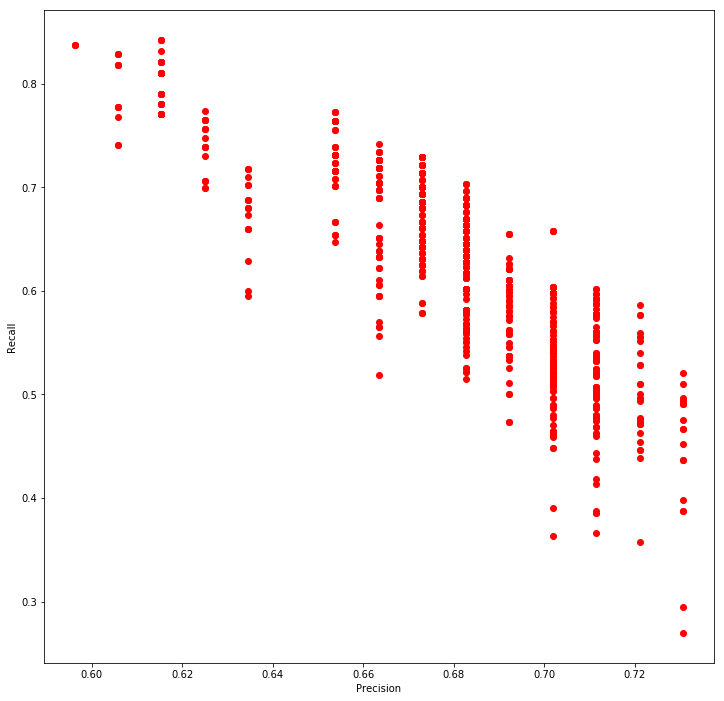

In [89]:
precision = []
recall = []
for path in tqdm.tqdm(glob.glob("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/*.json")):
    ddd = json.load(open(path))
    gt_per_detected = np.array(ddd["gt_per_detected"])
    detected_per_gt = np.array(ddd["detected_per_gt"])
    n_true_positives = np.sum(gt_per_detected > 0)
    n_false_positives = len(detected_per_gt) - n_true_positives
    n_false_negatives = len(gt_per_detected) - n_true_positives
    precision.append( float(n_true_positives) / (n_true_positives + n_false_positives))
    recall.append(float(n_true_positives) / (n_true_positives + n_false_negatives))
pylab.plot(precision, recall, "ro")
pylab.xlabel("Precision")
pylab.ylabel("Recall")
pylab.show()

In [91]:
result.keys()

['false_positive_labels',
 'true_positive_labels',
 'false_negative_labels',
 u'imin_slice',
 u'ithreshold',
 u'imin_size_3d',
 'precision',
 u'neuron_1',
 u'neuron_2',
 u'imax_size_2d',
 'n_false_positive_synapses',
 u'gt_per_detected',
 u'isigma_xy',
 'n_true_positive_synapses',
 u'synapse',
 'synapse_precision',
 'n_false_positives',
 'recall',
 u'detected_per_gt',
 'n_false_negatives',
 'synapse_recall',
 'n_true_positives',
 u'imin_size_2d',
 u'isigma_z',
 'synapse_map',
 u'path',
 'n_false_negative_synapses']

In [94]:
all_keys = list(keys) + ["n_true_positive_synapses", "n_false_negative_synapses", "n_false_positive_synapses", 
                         "synapse_precision", "synapse_recall",
                         "n_true_positives", "n_false_negatives", "n_false_positives",
                         "precision", "recall", "path"]
with open("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_statistics.csv", "w") as fd:
    fd.write('"' + ('","'.join(all_keys)) + '"\n')
    for result in stats_dict.values():
        first = True
        for key in all_keys:
            if first:
                first = False
            else:
                fd.write(",")
            value = result[key]
            if isinstance(value, basestring):
                value = '"%s"' % value
            else:
                value = str(value)
            fd.write(value)
        fd.write("\n")

In [95]:
! cat /n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_statistics.csv | head

"imin_size_2d","imax_size_2d","imin_size_3d","imin_slice","isigma_xy","isigma_z","ithreshold","n_true_positive_synapses","n_false_negative_synapses","n_false_positive_synapses","synapse_precision","synapse_recall","n_true_positives","n_false_negatives","n_false_positives","precision","recall","path"
900,15000,1225,2,0.5,2.25,80,74,29,58,0.560606060606,0.718446601942,108,162,180,0.375,0.4,"/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_0.50-2.25-80-900-15000-1225-2.h5"
100,15000,2500,4,5.25,0.5,104,73,30,58,0.557251908397,0.708737864078,108,162,157,0.407547169811,0.4,"/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_5.25-0.50-104-100-15000-2500-4.h5"
900,15000,1225,3,10.0,2.25,128,68,35,23,0.747252747253,0.660194174757,99,171,45,0.6875,0.366666666667,"/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_10.00-2.25-128-900-15000-1225-3.h5"
900,15000,1225,4,10.0,0.5,80,73,30,47,0.608333333333,0.708737864078,107,163,125,0.461206896552,0.3962962962

In [98]:
import pandas
pan = pandas.read_csv("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_statistics.csv")
pan

,imin_size_2d,imax_size_2d,imin_size_3d,imin_slice,isigma_xy,isigma_z,ithreshold,n_true_positive_synapses,n_false_negative_synapses,n_false_positive_synapses,synapse_precision,synapse_recall,n_true_positives,n_false_negatives,n_false_positives,precision,recall,path
0,900,15000,1225,2,0.50,2.25,80,74,29,58,0.560606,0.718447,108,162,180,0.375000,0.400000,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
1,100,15000,2500,4,5.25,0.50,104,73,30,58,0.557252,0.708738,108,162,157,0.407547,0.400000,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
2,900,15000,1225,3,10.00,2.25,128,68,35,23,0.747253,0.660194,99,171,45,0.687500,0.366667,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
3,900,15000,1225,4,10.00,0.50,80,73,30,47,0.608333,0.708738,107,163,125,0.461207,0.396296,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
4,400,15000,400,2,0.50,4.00,80,71,32,58,0.550388,0.689320,106,164,154,0.407692,0.392593,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
5,100,15000,400,3,0.50,0.50,104,73,30,113,0.392473,0.708738,108,162,208,0.341772,0.400000,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
6,900,15000,2500,2,10.00,0.50,128,68,35,36,0.653846,0.660194,100,170,81,0.552486,0.370370,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
7,400,15000,2500,3,0.50,4.00,128,65,38,26,0.714286,0.631068,80,190,69,0.536913,0.296296,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
8,100,15000,2500,4,0.50,2.25,80,74,29,71,0.510345,0.718447,108,162,201,0.349515,0.400000,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
9,400,15000,1225,3,0.50,0.50,80,75,28,92,0.449102,0.728155,111,159,207,0.349057,0.411111,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...


In [115]:
best = pan[(pan.synapse_precision>.78) & (pan.synapse_recall > .66)]
best

,imin_size_2d,imax_size_2d,imin_size_3d,imin_slice,isigma_xy,isigma_z,ithreshold,n_true_positive_synapses,n_false_negative_synapses,n_false_positive_synapses,synapse_precision,synapse_recall,n_true_positives,n_false_negatives,n_false_positives,precision,recall,path
128,900,15000,400,4,10.0,4.0,104,68,35,19,0.781609,0.660194,99,171,45,0.6875,0.366667,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
450,900,15000,2500,4,10.0,4.0,104,68,35,19,0.781609,0.660194,99,171,45,0.6875,0.366667,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
645,900,15000,1225,4,10.0,4.0,104,68,35,19,0.781609,0.660194,99,171,45,0.6875,0.366667,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...


In [129]:
best.iloc[0, -1]

'/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_10.00-4.00-104-900-15000-400-4.h5'

In [130]:
with h5py.File(best.iloc[0, -1], "r") as fd:
    sbest = fd["stack"][:]


In [151]:
dbest = json.load(open("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_10.00-4.00-104-900-15000-400-4.json"))
gt_per_detected = np.array(dbest["gt_per_detected"])
detected_per_gt = np.array(dbest["detected_per_gt"])
i, j = np.mgrid[0:sbest.shape[1], 0:sbest.shape[2]].astype(np.float32)
def drawbest(idx, show_syn, show_pred, show_gt):
    pylab.imshow(img[idx], cmap='gray')
    if show_syn:
        pylab.imshow(sbest[idx], cmap='tab20', alpha=.3)
    if show_pred:
        pylab.imshow(pred[idx], alpha=.2)
    if show_gt:
        mapping = np.hstack(([0], np.random.RandomState(1234).permutation(300)+1))
        pylab.imshow(mapping[gtp[idx]], cmap='tab20', alpha=.2)
    darea = np.bincount(sbest[idx].flatten())
    darea[0] = 0
    di = np.bincount(sbest[idx].flatten(), i.flatten())
    dj = np.bincount(sbest[idx].flatten(), j.flatten())
    mysyn = np.where(darea > 0)[0]
    darea = darea[mysyn]
    di = di[mysyn] / darea
    dj = dj[mysyn] / darea
    for myid, myi, myj in zip(mysyn, di, dj):
        pylab.annotate("%d: %d" % (myid, gt_per_detected[myid]), (myj, myi))
    darea = np.bincount(gt_syn_np[idx].flatten())
    darea[0] = 0
    di = np.bincount(gt_syn_np[idx].flatten(), i.flatten())
    dj = np.bincount(gt_syn_np[idx].flatten(), j.flatten())
    mysyn = np.where(darea > 0)[0]
    darea = darea[mysyn]
    di = di[mysyn] / darea
    dj = dj[mysyn] / darea
    for myid, myi, myj in zip(mysyn, di, dj):
        if detected_per_gt[myid] == 0:
            pylab.annotate("fn: %d" % myid, (myj, myi))
    pylab.show() 
interact(drawbest, idx=(0, len(pred)-1), show_syn=True, show_pred=False, show_gt=False)
        

<function __main__.drawbest>

In [ ]:
/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/
/n/coxfs01/paragt/lee_data/R0-test-synapse_gt/ecs-syn-tst-groundtruth-polarity.h5


In [141]:
with h5py.File("/n/coxfs01/paragt/lee_data/R0-test-synapse_gt/ecs-syn-tst-groundtruth-polarity.h5", "r") as fd:
    gtp = fd[fd.keys()[0]][:]
gtp.shape

(145, 1496, 1496)

In [155]:
gtp[gtp != 0] = (gtp[gtp != 0] - 1) / 2

In [156]:
detected_per_gt, gt_per_detected = match_synapses_by_overlap(gtp, sbest, 10)

In [160]:
float(np.sum(detected_per_gt > 0)) / (len(detected_per_gt) - 1)

0.6542056074766355

In [161]:
float(np.sum(gt_per_detected > 0)) / (len(gt_per_detected) - 1)

0.8045977011494253

In [148]:
len(gt_per_detected)

88

In [149]:
len(detected_per_gt)

217

In [153]:
np.min(gtp[gtp> 3])

4

In [159]:
dbest["synapse_precision"], dbest["synapse_recall"]

KeyError: 'synapse_precision'

In [210]:
isigma_xy = 15.0
isigma_z = 4.0
imin_size_2d = 900
imax_size_2d = 15000
imin_size_3d = 400
imin_slice = 4
ithreshold = 104
better = segment_vesicle_style(abspred, 
                               isigma_xy, 
                               isigma_z,
                               ithreshold, 
                               imin_size_2d,
                               imax_size_2d, 
                               imin_size_3d,
                               imin_slice)
detected_per_gt, gt_per_detected = match_synapses_by_overlap(gt_syn_np, better, 10)
print float(np.sum(detected_per_gt > 0)) / (len(detected_per_gt) - 1),\
float(np.sum(gt_per_detected > 0)) / (len(gt_per_detected) - 1)
syn, neuron_1, neuron_2 = connect_synapses(better, seg, pred)
path = "/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_%.2f-%.2f-%d-%d-%d-%d-%d" % (
    isigma_xy, isigma_z, ithreshold, imin_size_2d, imax_size_2d, imin_size_3d, imin_slice)
with h5py.File(path+".h5", "w") as fd:
    fd.create_dataset("stack", data=better)
d = dict(isigma_xy=isigma_xy, isigma_z=isigma_z, ithreshold=ithreshold, imin_size_2d=imin_size_2d,
         imax_size_2d=imax_size_2d, imin_size_3d=imin_size_3d, imin_slice=imin_slice,
         detected_per_gt = detected_per_gt.tolist(),
        gt_per_detected = gt_per_detected.tolist(),
        synapse=syn.tolist(),
        neuron_1=neuron_1.tolist(),
        neuron_2=neuron_2.tolist(),
        path=path+".h5")
json.dump(d, open(path+".json", "w"))

0.650485436893 0.817073170732


In [208]:
detected_per_gt, gt_per_detected = match_synapses_by_overlap(gtp, better, 10)
float(np.sum(detected_per_gt > 0)) / (len(detected_per_gt) - 1),\
float(np.sum(gt_per_detected > 0)) / (len(gt_per_detected) - 1)

(0.6542056074766355, 0.8536585365853658)

In [184]:
map(lambda _:(_, dbest[_]), keys)

[('imin_size_2d', 900),
 ('imax_size_2d', 15000),
 ('imin_size_3d', 400),
 ('imin_slice', 4),
 ('isigma_xy', 10.0),
 ('isigma_z', 4.0),
 ('ithreshold', 104)]

In [211]:
path

'/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_15.00-4.00-104-900-15000-400-4'

In [167]:
dbest["imin_size_2d"]

900

In [173]:
np.sum(better > 0)

0

In [175]:
help(segment_vesicle_style)

Help on function segment_vesicle_style in module ariadne_microns_pipeline.algorithms.segmentation:

segment_vesicle_style(prob, sigma_xy, sigma_z, threshold, min_size_2d, max_size_2d, min_size_3d, min_slice)
    Segment according to the "Vesicle" algorithm
    
    See http://arxiv.org/abs/1403.3724
    VESICLE: Volumetric Evaluation of Synaptic Interfaces using Computer
             vision at Large Scale
    William Gray Roncal, Michael Pekala, Verena Kaynig-Fittkau, 
    Dean M. Kleissas, Joshua T. Vogelstein, Hanspeter Pfister, Randal Burns, 
    R. Jacob Vogelstein, Mark A. Chevillet, Gregory D. Hager
    
    :param prob: The synapse probability volume with axes of z, y, and x
    :param sigma_xy: The sigma for the smoothing gaussian in the x and y
                     directions
    :param sigma_z: The sigma for the smoothing Gaussian in the z direction
    :param threshold: The probability threshold above which, a voxel is
                      deemed to be part of a synapse.
  

In [177]:
pred.max()

1.0954869